In [1]:
# spustite si server pre deep learning, ktory ma nainstalovany tensorflow a keras 
# (File - Hub Control Panel ... Stop server, nasledne start ... a vyberte Jupyter Notbeook Deep Learning Stack )

# naimportujeme si potrebné knižnice a typy
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras import utils
import pandas as pd
from sklearn.metrics import classification_report

In [2]:
# nacitame si data dostupne priamo v kerase - MNIST data, ide o rucne pisane cislice
((trainX, trainY), (testX, testY)) = mnist.load_data()

11490434/11490434 [==============================] - 3s 0us/step


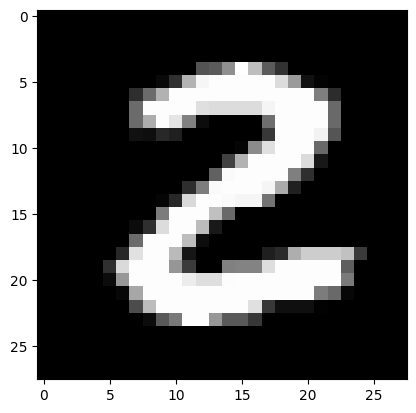

In [4]:
# jeden konkretny priklad cislice 
plt.imshow(trainX[25], cmap='gray')

In [6]:
# pre neuronove siete sa odporuca vstupy normalizovat - potrebujeme hodnoty pixelov (jas) normalizovat tak aby boli mensie ako 1, v tomto pripade teda na interval [0,1]
# kedze hodnoty jasu su od 0 do 255, zmenime typ na float a predelime ich /255
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

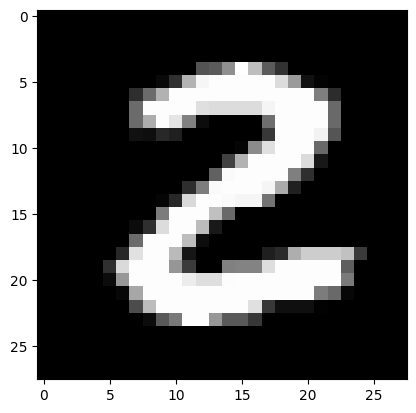

In [9]:
# aj ked sa skala zmenila, obrazok vykresleny cez plt.imshow vidime ze vyzera rovnako, takze sme to zjavne neurobil chybu pri skalovani
plt.imshow(trainX[25], cmap='gray')

In [10]:
# vytvorenie modelu ... sekvencne, povedzme ze urobime jednoduchu siet ktora pozostava z konvolucnej casti a doprednej casti siete
# akakolvek vrstva je prva, musi definovat input_shape vstupov, ktore sa pre nu budu pouzivat - u nas (28,28,1) pre obrazky 28*28 v 1 "farbe" (urovne jasu)
# ak chceme pouzit konvolucne vrstvy a pooling vrstvy, dame ich pred flatten vrstvu
# mozeme zakomponovat aj regularizaciu, napr. dropout
# Dense vrstvy su plne prepojene vrstvy pouzivane na klasifikaciu - representuju feed forward siet, postupne zmensujeme pocet neuronov vo vrstve a tak ucime kompaktnejsiu reprezentaciu
# posledna vrstva ma tolko neuronov, kolko je binarnych vystupov pre reprezentaciu toho, ktora cislica to je - cize 10 neuronov v nasom pripade, typ aktivacie softmax 
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(10, activation="softmax"))

# pomocou summary si vieme zobrazit strukturu modelu
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               692352    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [11]:
# skompilujeme model ... ide o akesi nastavenie celeho mechanizmu ucenia siete (samotne ucenie bude ako tradicne pomocou fit)
# optimizer je typ optimalizacneho algoritmu, pouzijeme oblubeny algoritmus Adam, s default nastaveniami (preto prazdna zatvorka pri volani)
# pre chybovu funkciu loss sa pre viac tried pozuiva categorical_crossentropy, ako metriku na urcenie kvality klasifikacie pouzijeme accuracy
# v pripade binarnej klasifikacie sa pouziva vystupna vrstva sigmoid (posledna Dense vrstva) a loss funkcia sa potom tu pozuije binary_crossentropy
adam = Adam()
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [12]:
# pre skompilovany model mozeme nasledne spustit proces ucenia pomocou fit
# mozeme pouzit validation_split a definovat kolko s trenovacej mnoziny bude pouzite samostatne ako validacna mnozina
# pripadne mozeme nastavit validacnu mnozinu samostatne (validation_data), alebo ju vobec nepouzit
# tiez musime cielove hodnoty trenovacej sady (trainY) pre potreby trenovania neuronovej siete zakodovat ako binarny vektor, kedze ich musime mapovat na softmax vrstvu s 10 neuronmi
# mozeme pouzit napr. utils funkciu kniznice keras to_categorical, vysledkom je napr. cislica 3 je zakodovane takto [0,0,0,1,0,0,0,0,0,0], cislica 7 zase [0,0,0,0,0,0,0,1,0,0] atd.
# dosiahneme to pouzitim utils.to_categorical(trainY, 10)
f = model.fit(trainX, utils.to_categorical(trainY, 10), epochs=2, batch_size=32, validation_split=0.1)

Epoch 1/2
1688/1688 [==============================] - 28s 15ms/step - loss: 0.9840 - accuracy: 0.6923 - val_loss: 0.3257 - val_accuracy: 0.9112
Epoch 2/2
1688/1688 [==============================] - 28s 17ms/step - loss: 0.4404 - accuracy: 0.8657 - val_loss: 0.2338 - val_accuracy: 0.9335


In [13]:
# skusme predikciu konkretnej cislice, napr. index 32 (cize podmnozinu testX od 32 po 33 bez 33 - python)
# dostaneme aktivacne hodnoty na jednotlivych neuronoch vystupnej vrstvy - je to binarne zakodovana cislica, jedna hodnota je vyrazne vacsia, zodpoveda neuronu pre danu cislicu
some_prediction = model.predict(testX[32:33])
some_prediction

1/1 [==============================] - 0s 170ms/step


array([[1.68277293e-05, 3.19315332e-05, 3.87972599e-04, 9.51573789e-01,
        3.40536394e-06, 4.12853099e-02, 1.92550283e-06, 1.50632495e-05,
        6.60288148e-03, 8.08132463e-05]], dtype=float32)

<BarContainer object of 10 artists>

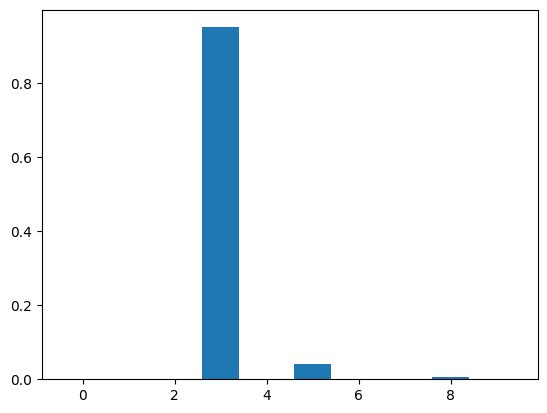

In [15]:
# ako vyzeraju rozdiely v hodnotach predikcie si mozeme pozriet aj na grafe, ukaze nam poziciu najvacsej hodnoty
# podla toho kde je vidime, ze index pozicie je 3 -> cize cislica je 3
plt.bar(np.arange(10), some_prediction[0])

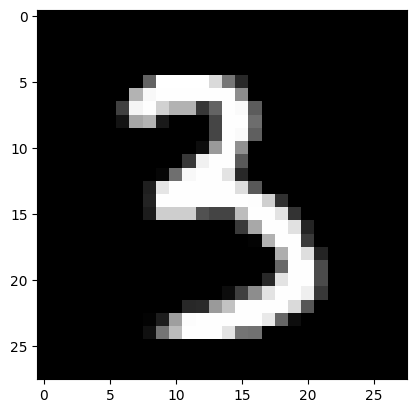

In [16]:
# na porovnanie vykreslime obrazok daneho testovacieho prikladu, vidime ze skutocne ide o 3, predikcia bola uspesna
plt.imshow(testX[32], cmap='gray')

In [17]:
# vytvorime si predikcie na celej testX a prerobime ich na konkretnu hodnotu kategorie (cislicu) tak ze zistime argument (index) maximalnej hodnoty v ramci predikovaneho bin.vektora
y_predictions = model.predict(testX)
y_predicted_categories = np.argmax(y_predictions, axis = 1)

313/313 [==============================] - 2s 6ms/step


In [18]:
# mozeme si vypisat predikovane hodnoty kategorii pre jednotlive prvky testX
y_predicted_categories

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [19]:
# vidime ze pre 32 zaznam to opat sedi, hodnota je 3
y_predicted_categories[32]

3

In [20]:
# vytvorime confusion matrix na testovacej mnozine porovnanim predikovanych (y_predicted_ctaegories) a skutocnych hodnot y (testY) prikladov v testovacej mnozine
pd.crosstab(testY, y_predicted_categories)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,962,0,1,2,0,5,6,1,3,0
1,0,1112,4,2,0,2,3,1,11,0
2,12,2,932,13,12,1,16,12,31,1
3,2,4,21,906,1,25,3,13,27,8
4,1,3,6,1,893,1,15,3,2,57
5,17,4,6,36,11,772,10,2,27,7
6,18,3,6,0,10,18,899,1,3,0
7,4,15,21,5,7,0,0,932,2,42
8,8,7,6,21,8,22,11,12,868,11


In [21]:
# mozeme vypisat aj klasifikacny report 
print(classification_report(testY, y_predicted_categories))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.92      1032
           3       0.91      0.90      0.90      1010
           4       0.92      0.91      0.92       982
           5       0.90      0.87      0.88       892
           6       0.93      0.94      0.94       958
           7       0.94      0.91      0.92      1028
           8       0.89      0.89      0.89       974
           9       0.88      0.91      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

